In [1]:
from matplotlib import pyplot as plt
import os
from copy import copy
import numpy as np
import pandas as pd
from datetime import timedelta

from autumn.core.runs.managed import ManagedRun
from autumn.core.project import get_project

### Select the run of interest and some plotting options

In [2]:
run_id = "sm_sir/national-capital-region/1662011975/afa15f9"

colours = ["cornflowerblue", "darkorange", "mediumseagreen", "pink", "purple"]
xmin, xmax = pd.to_datetime("2021-11-01"), pd.to_datetime("2023-07-01")

### Load project and derived outputs

In [3]:
model, region = run_id.split("/")[0:2]
project = get_project(model, region, reload=True)
age_groups = project.param_set.baseline['age_groups']
mr = ManagedRun(run_id)
pbi = mr.powerbi.get_db()
derived_outputs = pbi.get_derived_outputs()
scenarios = pbi.scenarios.index.to_list()

### Create output directory

In [4]:
base_dir = os.path.join("outputs", run_id.replace("/", "#"), "incidence_by_age")
os.makedirs(base_dir, exist_ok=True)

### Create plotting function

In [5]:
def plot_incidence_by_age(ax, scenario, as_proportion: bool):
    y_label = "COVID-19 incidence proportion" if as_proportion else "COVID-19 incidence"    

    times = derived_outputs["incidence", scenario].index.to_list()
    running_total = [0] * len(derived_outputs["incidence", scenario])

    for i_age, age_group in enumerate(age_groups):
        output_name = f"incidenceXagegroup_{age_group}"
    
        if i_age < len(age_groups) - 1:
            upper_age = age_groups[i_age + 1] - 1 if i_age < len(age_groups) - 1 else ""
            age_group_name = f"{age_group}-{upper_age}"
        else:
            age_group_name = f"{age_group}+"

        age_group_incidence = derived_outputs[output_name, scenario]
        
        if as_proportion:
            numerator, denominator = age_group_incidence, derived_outputs["incidence", scenario]
            age_group_proportion = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
            new_running_total = age_group_proportion + running_total
        else: 
            new_running_total = age_group_incidence + running_total 

        ax.fill_between(times, running_total, new_running_total, color=colours[i_age], label=age_group_name)
        running_total = copy(new_running_total)

    # add dashed line to indicate school reopening for NCR
    if region == "national-capital-region":
        reopening_date = pd.to_datetime("2022-08-22")
        ymax = ax.get_ylim()[1]
        ax.vlines(x=reopening_date, ymin=0., ymax=ymax, color="black", dashes="--", linewidth=1)
        if not as_proportion:
            ax.text(x=reopening_date + timedelta(days=5), y=ymax, s="school reopening", fontsize=12)

    ax.set_xlim((xmin, xmax))
    ax.set_ylabel(y_label)

    if not as_proportion:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            reversed(handles),
            reversed(labels),
            title="Age:",
            fontsize=12,
            title_fontsize=12,
            labelspacing=.5,
            facecolor="white"
        )

### Generate the figures

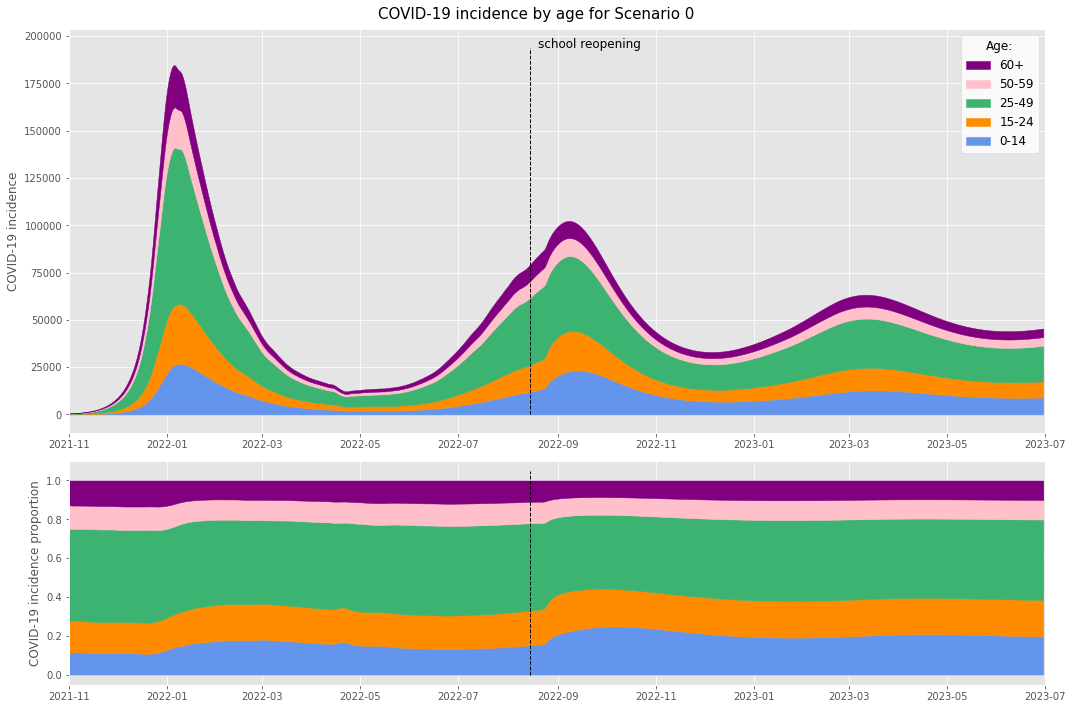

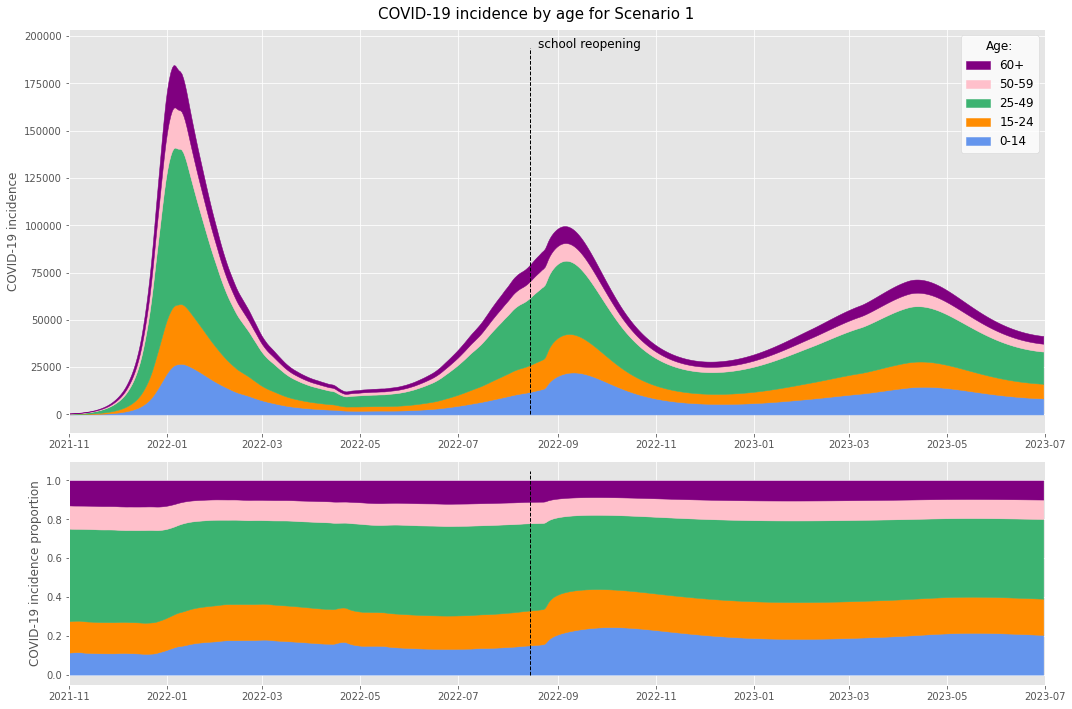

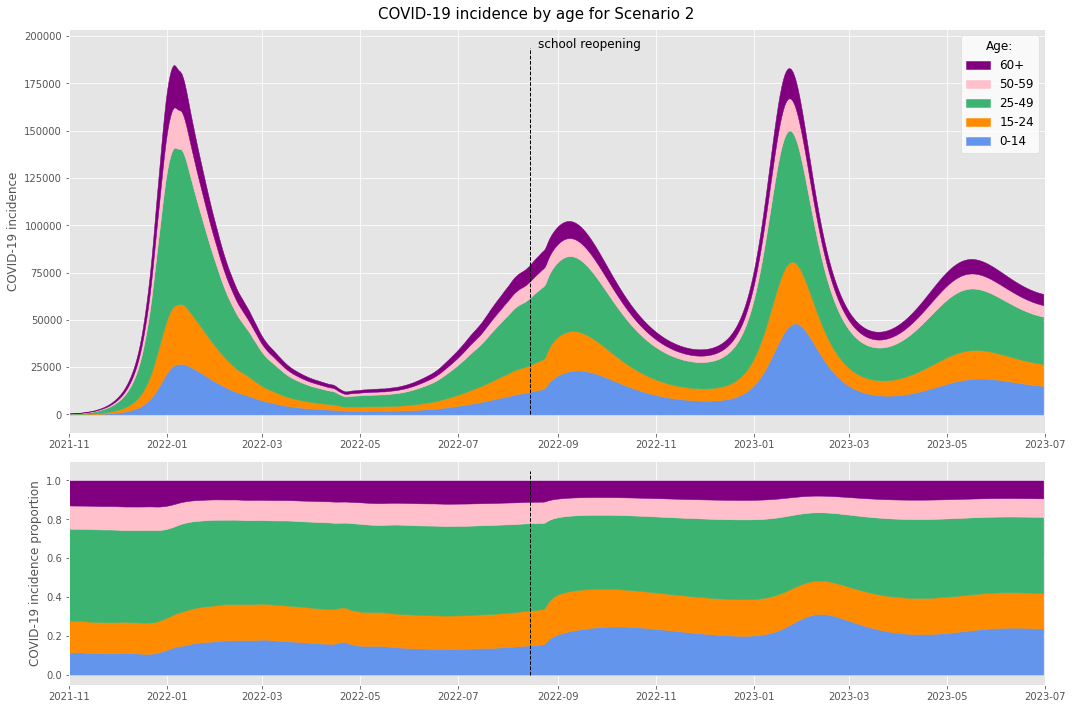

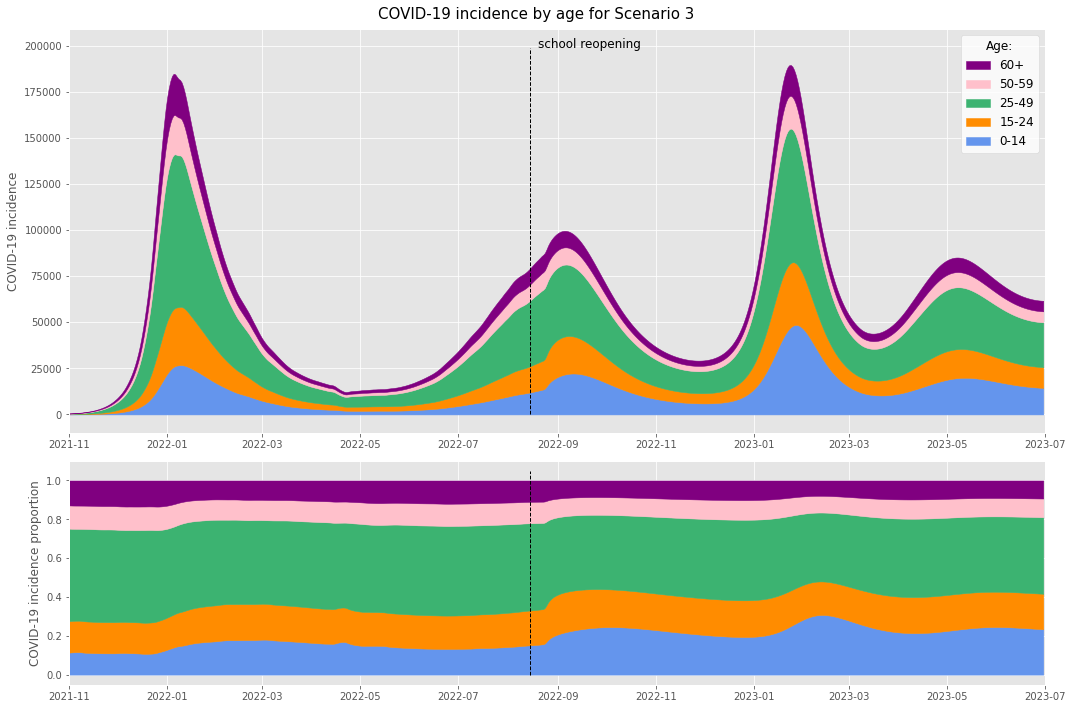

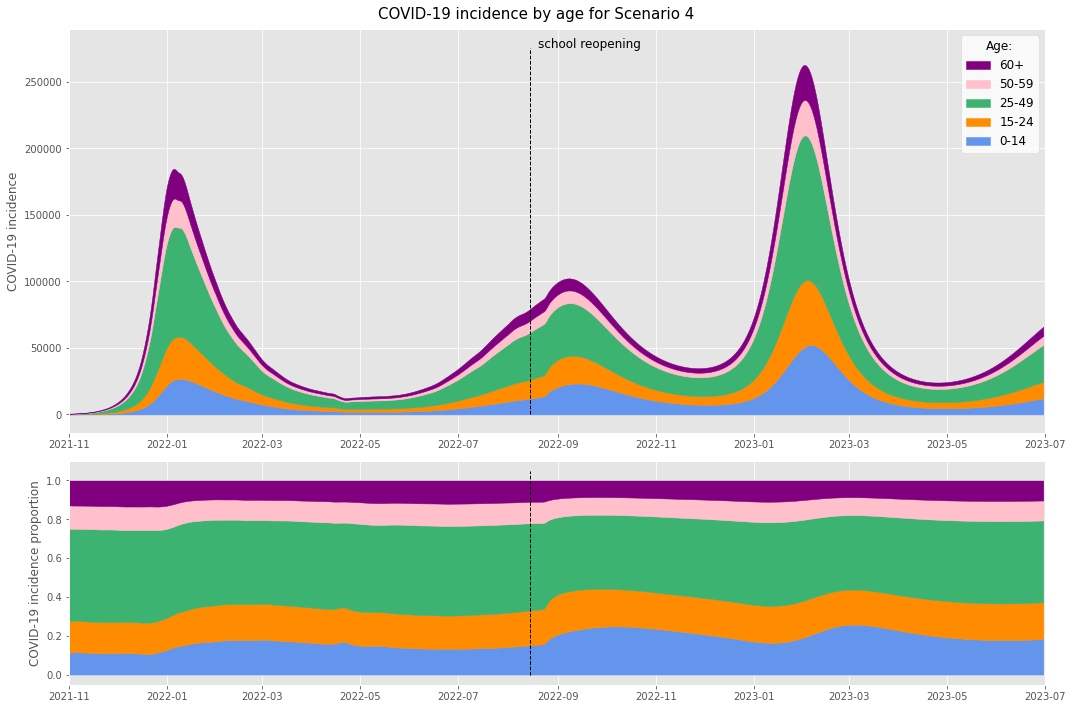

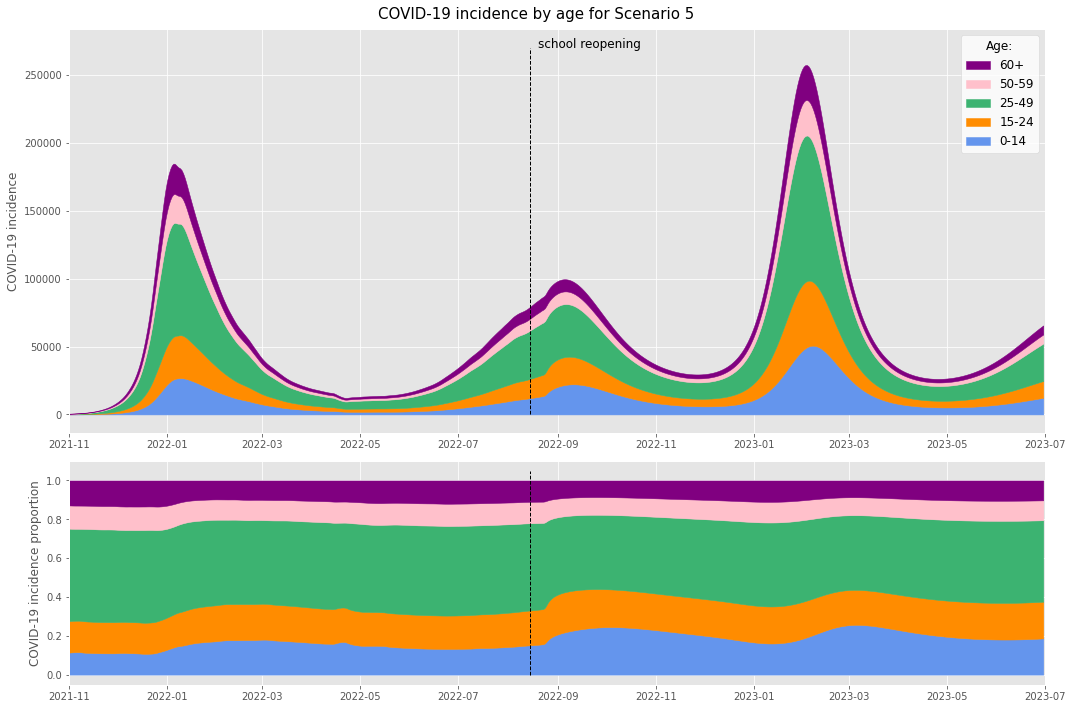

In [6]:
plt.style.use("ggplot")
for scenario in scenarios:    
    fig, axes = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [1.8, 1]})
    for i, as_proportion in enumerate([False, True]):
        plot_incidence_by_age(axes[i], scenario, as_proportion)

    fig.suptitle(f"COVID-19 incidence by age for Scenario {scenario}", fontsize=15)
    fig.subplots_adjust(top=.92)

    plt.tight_layout()
    path = os.path.join(base_dir, f"incidence_by_age_scenario_{scenario}.png")
    plt.savefig(path, dpi=300)